# ACOL replication tensorflow

## Setup stuff

In [65]:
import os
perc = float(os.environ.get('perc', 0.001))
balanced = bool(os.environ.get('balanced', True))

In [66]:
print("Percentage subclass labelled: %g"%(perc))
print("Balanced: %r"%(balanced))

Percentage subclass labelled: 1
Balanced: True


In [67]:
from notifiers import notify
import random

#imports and settings: 
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#from jupyterthemes import jtplot
from sklearn.cluster import KMeans
from scipy.stats import threshold
from tensorflow.contrib.learn.python.learn.datasets import base
from tensorflow.contrib.learn.python.learn.datasets import mnist
#jtplot.style()
%matplotlib inline
tf.logging.set_verbosity(tf.logging.INFO)

TRAIN_IMAGES = 'train-images-idx3-ubyte.gz'
TRAIN_LABELS = 'train-labels-idx1-ubyte.gz'
TEST_IMAGES = 't10k-images-idx3-ubyte.gz'
TEST_LABELS = 't10k-labels-idx1-ubyte.gz'
SOURCE_URL = 'https://storage.googleapis.com/cvdf-datasets/mnist/'

local_file = base.maybe_download(TRAIN_IMAGES, './MNIST_data',
                                   SOURCE_URL + TRAIN_IMAGES)
with open(local_file, 'rb') as f:
    train_images = mnist.extract_images(f)
    
local_file = base.maybe_download(TRAIN_LABELS, './MNIST_data',
                                   SOURCE_URL + TRAIN_LABELS)
with open(local_file, 'rb') as f:
    train_labels = mnist.extract_labels(f, one_hot=True)

local_file = base.maybe_download(TEST_IMAGES, './MNIST_data',
                                   SOURCE_URL + TEST_IMAGES)
with open(local_file, 'rb') as f:
    test_images = mnist.extract_images(f)

local_file = base.maybe_download(TEST_LABELS, './MNIST_data',
                                   SOURCE_URL + TEST_LABELS)
with open(local_file, 'rb') as f:
    test_labels = mnist.extract_labels(f, one_hot=True)

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


In [68]:
#def notify(body):
#    msg = MIMEText(body)
#    # me == the sender's email address
    # you == the recipient's email address
#    msg['Subject'] = 'Finished training!'
#    msg['From'] = "scriptnotificiations@gmail.com"
#    msg['To'] = "scriptnotificiations@gmail.com"

    # Send the message via our own SMTP server, but don't include the
    # envelope header.
#    s = smtplib.SMTP('smtp.gmail.com', 587)
#    s.starttls()
#    s.login("scriptnotificiations@gmail.com", "SuperSecretMegaPassword!!!")
#    s.sendmail("scriptnotificiations@gmail.com", ["scriptnotificiations@gmail.com"], msg.as_string())
#    s.quit()

In [69]:
#clustCount = 5
classCount = 2
net = 0
trainsteps = 30000

#trainsteps = 30000

perc = 0.01
balance = False

validation_size=5000
_epochs_completed_train = 0
_index_in_epoch_train = 0
_epochs_completed_val = 0
_index_in_epoch_val = 0
_epochs_completed_test = 0
_index_in_epoch_test = 0

In [70]:
#test_images=test_images[:int(60000*perc)]
#test_labels=test_labels[:int(60000*perc)]

#train_super_labels = np.array([y[np.argmax(train_labels[j])] for j in range(60000)])
#train_labels_clipped = np.array([train_labels[j] for j in range(int(60000*perc))])
#train_labels_clipped = np.concatenate([train_labels_clipped,np.array([train_labels[j] for j in range(int(60000*perc),60000)])])

In [71]:
if not 0 <= validation_size <= len(train_images):
    raise ValueError(
        'Validation size should be between 0 and {}. Received: {}.'
        .format(len(train_images), validation_size))

validation_images = train_images[:validation_size]
validation_labels = train_labels[:validation_size]
#validation_super_labels = train_super_labels[:validation_size]
#validation_labels_clipped = train_labels_clipped[:validation_size]
train_images = train_images[validation_size:]
train_labels = train_labels[validation_size:]
#train_super_labels = train_super_labels[validation_size:]
#train_labels_clipped = train_labels_clipped[validation_size:]

train_images = train_images.reshape(train_images.shape[0],train_images.shape[1] * train_images.shape[2])
train_images = train_images.astype(np.float32)
train_images = np.multiply(train_images, 1.0 / 255.0)

validation_images = validation_images.reshape(validation_images.shape[0],validation_images.shape[1] * validation_images.shape[2])
validation_images = validation_images.astype(np.float32)
validation_images = np.multiply(validation_images, 1.0 / 255.0)

test_images = test_images.reshape(test_images.shape[0],test_images.shape[1] * test_images.shape[2])
test_images = test_images.astype(np.float32)
test_images = np.multiply(test_images, 1.0 / 255.0)

trainCount=len(train_images)
if balance:
    inds = []
    classSize = int(np.ceil(trainCount*perc/10))
    for j in range(10):
        inds.extend([i for i, x in enumerate(np.argmax(train_labels,1)) if x == j][:classSize])
    random.shuffle(inds)

    train_images=train_images[inds,:]
    train_labels=train_labels[inds,:]
else:
    train_images=train_images[:int(trainCount*perc),:]
    train_labels=train_labels[:int(trainCount*perc),:]
    
print np.unique(np.argmax(train_labels,1),return_counts=True)
#    options = dict(dtype=dtypes.float32, reshape=True, seed=None)
  
#    train = DataSet(train_images, train_labels, **options)
#    validation = DataSet(validation_images, validation_labels, **options)
#    test = DataSet(test_images, test_labels, **options)
  
#    mnist = base.Datasets(train=train, validation=validation, test=test)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([68, 58, 52, 62, 51, 40, 50, 57, 56, 56]))


In [72]:
def next_batch(batch_size, shuffle, images, labels, ep_compl, ep_ind):
    _epochs_completed = ep_compl
    _index_in_epoch = ep_ind
    """Return the next `batch_size` examples from this data set."""
    start = _index_in_epoch
    _num_examples = images.shape[0]
    # Shuffle for the first epoch
    if _epochs_completed == 0 and start == 0 and shuffle:
      perm0 = np.arange(_num_examples)
      np.random.shuffle(perm0)
      _images = images[perm0]
      _labels = labels[perm0]
    # Go to the next epoch
    if start + batch_size > _num_examples:
      # Finished epoch
      _epochs_completed += 1
      # Get the rest examples in this epoch
      rest_num_examples = _num_examples - start
      images_rest_part = _images[start:_num_examples]
      labels_rest_part = _labels[start:_num_examples]
      # Shuffle the data
      if shuffle:
        perm = np.arange(_num_examples)
        np.random.shuffle(perm)
        _images = images[perm]
        #print(_images)
        _labels = labels[perm]
      # Start next epoch
      start = 0
      _index_in_epoch = batch_size - rest_num_examples
      end = _index_in_epoch
      images_new_part = _images[start:end]
      labels_new_part = _labels[start:end]
      l = np.concatenate((labels_rest_part, labels_new_part), axis=0)
      return np.concatenate((images_rest_part, images_new_part), axis=0) , np.vstack([np.sum(l[:,:5],1),np.sum(l[:,5:],1)]).T
    else:
      _index_in_epoch += batch_size
      end = _index_in_epoch
      return _images[start:end], np.vstack([np.sum(_labels[start:end,:5],1),np.sum(_labels[start:end,5:],1)]).T

## Network helper functions

In [73]:
#helper funcs
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def matrix_softmax(x):
    shape = x.get_shape().as_list()
    shape[0] = int(-1)
    return tf.reshape(tf.nn.softmax(tf.contrib.layers.flatten(x)),shape)

def avg_softmax(x):
    shape = x.get_shape().as_list()
    shape[0] = int(-1)
    totalSoft = tf.reshape(tf.nn.softmax(tf.contrib.layers.flatten(x)),shape)
    return tf.reduce_sum(totalSoft,2)

def max_softmax(x):
    shape = x.get_shape().as_list()
    shape[0] = int(-1)
    totalSoft = tf.reshape(tf.nn.softmax(tf.contrib.layers.flatten(x)),shape)
    return tf.reduce_max(totalSoft,2)

def initACOL(in_size,clust,clss):
    acolLayers = []
    for i in range(clss):
        acolLayers.append([
            weight_variable([in_size, clustCount]),
            bias_variable([clustCount])
        ])
    return acolLayers
        
def connectACOL(inLayer,acol):
    clust = []
    for l in range(0,len(acol)):
        clust.append(tf.matmul(inLayer, acol[l][0]) + acol[l][1])
    return clust
        
def acol(input,clust_count, class_count):
    acolLayers = []
    for i in range(class_count):
        if isinstance(input, tuple):
                input = input[0]

        #I don't know what this bit does, but I don't think it'll hurt anything
        #Or maybe it does, who knows
        input_shape = input.get_shape()
        if input_shape.ndims == 4:
            dim = 1
            for d in input_shape[1:].as_list():
                dim *= d
        #    feed_in = tf.reshape(tf.transpose(input,[0,3,1,2]), [-1, dim])
        else:
            feed_in, dim = (input, int(input_shape[-1]))

        init_weights = tf.truncated_normal_initializer(0.0, stddev=0.1)#(0.0, stddev=0.01)
        init_biases = tf.constant_initializer(1.0)#(0.1)

        weights = weight_variable([dim, clust_count])
        biases = bias_variable([clust_count])

        acoll = tf.nn.xw_plus_b(input,weights,biases)
        acolLayers.append(acol)
    return acolLayers    


## Create placeholders (weights&biases)

In [74]:
if net==0:
    #Init model weights & biases
    sess = tf.InteractiveSession()
    
    keep_prob = tf.placeholder(tf.float32)
    x = tf.placeholder(tf.float32, shape=[None, 784])
    x_image = tf.reshape(x, [-1,28,28,1])
    #y_ = tf.placeholder(tf.float32, shape=[None, classCount])
    y_ = tf.placeholder(tf.float32, shape=[None,classCount])
    
    #conv_layer1
    W_conv1 = weight_variable([5,5,1,32])
    b_conv1 = bias_variable([32])

    #conv_layer2
    W_conv2 = weight_variable([5,5,32,64])
    b_conv2 = bias_variable([64])

    #fc layer 1
    W_fc1 = weight_variable([7*7*64, 1024])
    b_fc1 = bias_variable([1024])

    #acol = initACOL(1024,clustCount,classCount)

    #final fc layer
    W_fc2 = weight_variable([1024, classCount])
    b_fc2 = bias_variable([classCount])

### Define network

In [75]:
if net==0:
    dropout=0.3
    #Define net
    #conv 1
    l_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    l_pool1 = max_pool_2x2(l_conv1)

    #conv 2
    l_conv2 = tf.nn.relu(conv2d(l_pool1, W_conv2) + b_conv2)
    l_pool2 = max_pool_2x2(l_conv2)

    #fc 1
    l_pool2_flat = tf.reshape(l_pool2, [-1, 7*7*64])
    l_fc1 = tf.nn.relu(tf.matmul(l_pool2_flat, W_fc1) + b_fc1)

    l_fc1_drop = tf.nn.dropout(l_fc1, keep_prob)

    y_conv = tf.nn.softmax(tf.matmul(l_fc1_drop, W_fc2) + b_fc2)
    
    #l_acol = connectACOL(l_fc1_drop,acol)
    #l_acol = acol(l_fc1_drop,clustCount,classCount)

    #Classification layer
    #stackedClusts = tf.stack(l_acol,1)
    #softmaxMat = matrix_softmax(stackedClusts)
    #smStacked = tf.reduce_max(softmaxMat,2)

    #y_conv = smStacked

## Helperfunctions for loss

In [76]:
#helper loss funcs
def zBar(x):
    xshape = x.shape.as_list()
    s=[-1,xshape[1]*xshape[2]]
    return tf.maximum(tf.reshape(x,s),0)
    
def bigU(zb):
    return tf.matmul(tf.transpose(zb),zb)

def selectNonDiag(x):
    selection = np.ones(x.shape.as_list()[0],dtype='float32') - np.eye(x.shape.as_list()[0],dtype='float32')
    return tf.reduce_sum(tf.multiply(x,selection))

def bigV(x):
    smallNu=tf.reshape(tf.reduce_sum(x,axis=0),[1,-1])
    return tf.multiply(tf.transpose(smallNu),smallNu)

def specialNormalise(x):
    top = selectNonDiag(x)
    bottom = tf.multiply(tf.to_float(x.shape[1]-1),tf.reduce_sum(tf.multiply(x,np.eye(x.shape[1],dtype='float32'))))
    return tf.divide(top,bottom)

def frobNorm(x):
    return tf.sqrt(tf.reduce_sum(tf.square(x)))

tresh = tf.constant(0.03)
cc0=1.0
cc1=1.0
cc2=1.0
cc3=0.0003
cc4=0.000001
cc5=1.0
c0 = tf.constant(cc0)
c1 = tf.constant(cc1)
c2 = tf.constant(cc2)
c3val = tf.constant(cc3)
c3 = lambda affinity: tf.cond(tf.less(affinity,tresh),lambda: c3val,lambda: tf.constant(0.0))
c4 =tf.constant(cc4)
c5 = tf.constant(cc5)

### Calculate loss

In [77]:
#calculate losses
#affinity
#bZ = zBar(stackedClusts)#softmaxMat)
#bU = bigU(bZ)
#coact = selectNonDiag(bU)
#affinity = specialNormalise(bU)

#balance
#bV=bigV(bZ)
#balance = specialNormalise(bV)

#cluster cross entropy (added if secondary label is set for that input, hard to do with batches?)
#clust_cross_entropy = tf.reduce_mean(-tf.reduce_sum(y2_ * tf.log(tf.clip_by_value(softmaxMat,1e-10,1.0)), reduction_indices=[1,2]))

#cross entropy
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(tf.clip_by_value(y_conv,1e-10,1.0)), reduction_indices=[1]))

#frob = frobNorm(stackedClusts)#softmaxMat)

loss = c0*cross_entropy# + c5*clust_cross_entropy# + c1*affinity + c2*tf.subtract(tf.constant(1.0),balance) + c3(affinity)*coact + c4*frob

## Train network

In [78]:
lr = 1e-5
train_step = tf.train.AdamOptimizer(lr).minimize(loss)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())

In [79]:
totalSteps = trainsteps
stepCount=0
batchSize = 128
hist = {
    'train_acc':[],
    'val_acc':[],
    'train_loss':[],
    'val_loss':[],
    'affinity':[],
    'balance':[],
    'coactivity':[]
}

In [80]:
#totalSteps = int(totalSteps*perc)
print totalSteps
dropout=0.3
for i in range(20000):
    #if i > totalSteps*perc:
    #   convy2 = emptyy2
        
    trainbatch = next_batch(batchSize,True,train_images, train_labels,_epochs_completed_train,_index_in_epoch_train)
    trainbatch = (trainbatch[0],trainbatch[1])
    valbatch = next_batch(batchSize,True,validation_images, validation_labels,_epochs_completed_val,_index_in_epoch_val)
    valbatch = (valbatch[0],valbatch[1])
    
    if i%100 == 0:
        train_loss,train_acc = sess.run([loss, accuracy],feed_dict={x: trainbatch[0], y_: trainbatch[1],keep_prob:dropout})
        val_loss, val_acc = sess.run([loss, accuracy],feed_dict={x: valbatch[0], y_: valbatch[1],keep_prob:dropout})
        hist['train_acc'].append(train_acc)
        hist['val_acc'].append(val_acc)
        hist['train_loss'].append(train_loss)
        hist['val_loss'].append(val_loss)
        print("step %d/%d \n Train: accuracy: %g, loss: %g \n Validation: accuracy: %g loss: %g"%(i,totalSteps, train_acc, train_loss, val_acc, val_loss))
        #hist['affinity'].append(affinity.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1]}))
        #hist['balance'].append(balance.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1]}))
        #hist['coactivity'].append(coact.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1]}))
        entr = cross_entropy.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1],keep_prob:dropout})
        #entr2 = clust_cross_entropy.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1]})
        #frb = frob.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1]})
        
        #print bV.eval(feed_dict={x:trainbatch[0], y_: trainbatch[1]})
        
        print(" cross_entropy: %g"%(cc0*entr))
    feed_dict={x: trainbatch[0], y_: trainbatch[1],keep_prob:dropout}
    _ = sess.run([train_step],feed_dict=feed_dict)

30000
step 0/30000 
 Train: accuracy: 0.5, loss: 4.08725 
 Validation: accuracy: 0.460938 loss: 3.99553
 cross_entropy: 4.83651
step 100/30000 
 Train: accuracy: 0.5, loss: 2.44548 
 Validation: accuracy: 0.59375 loss: 2.26196
 cross_entropy: 3.01838
step 200/30000 
 Train: accuracy: 0.632812, loss: 1.75166 
 Validation: accuracy: 0.5 loss: 2.95306
 cross_entropy: 2.44697
step 300/30000 
 Train: accuracy: 0.71875, loss: 1.32536 
 Validation: accuracy: 0.632812 loss: 1.51845
 cross_entropy: 1.29104
step 400/30000 
 Train: accuracy: 0.710938, loss: 1.29436 
 Validation: accuracy: 0.640625 loss: 1.3868
 cross_entropy: 1.2097
step 500/30000 
 Train: accuracy: 0.773438, loss: 0.85183 
 Validation: accuracy: 0.65625 loss: 1.11527
 cross_entropy: 1.03925
step 600/30000 
 Train: accuracy: 0.820312, loss: 0.538015 
 Validation: accuracy: 0.742188 loss: 1.03724
 cross_entropy: 0.721099
step 700/30000 
 Train: accuracy: 0.789062, loss: 0.609031 
 Validation: accuracy: 0.789062 loss: 0.525967
 cro

In [81]:
notify("Hello! Look at me plz!")

## Testing & visualising

In [82]:
tAcc = []
testSize = 1000
for i in range(100):
    testbatch = next_batch(batchSize,True,test_images, test_labels,_epochs_completed_test,_index_in_epoch_test)

    test_loss,test_acc = sess.run([loss,accuracy],{x: testbatch[0], y_: testbatch[1],keep_prob:1.0})
    tAcc.append(test_acc)
    print('Test: accuracy: %g, loss: %g'%(test_acc,test_loss))
print np.average(tAcc)

Test: accuracy: 0.921875, loss: 0.460464
Test: accuracy: 0.953125, loss: 0.240423
Test: accuracy: 0.90625, loss: 0.411602
Test: accuracy: 0.976562, loss: 0.118302
Test: accuracy: 0.929688, loss: 0.235217
Test: accuracy: 0.914062, loss: 0.413159
Test: accuracy: 0.921875, loss: 0.287485
Test: accuracy: 0.90625, loss: 0.364238
Test: accuracy: 0.945312, loss: 0.2847
Test: accuracy: 0.9375, loss: 0.246796
Test: accuracy: 0.9375, loss: 0.33088
Test: accuracy: 0.945312, loss: 0.211042
Test: accuracy: 0.96875, loss: 0.117954
Test: accuracy: 0.96875, loss: 0.0870858
Test: accuracy: 0.953125, loss: 0.118562
Test: accuracy: 0.96875, loss: 0.175393
Test: accuracy: 0.898438, loss: 0.644947
Test: accuracy: 0.960938, loss: 0.127328
Test: accuracy: 0.898438, loss: 0.40935
Test: accuracy: 0.960938, loss: 0.420483
Test: accuracy: 0.914062, loss: 0.324656
Test: accuracy: 0.96875, loss: 0.225876
Test: accuracy: 0.960938, loss: 0.117718
Test: accuracy: 0.929688, loss: 0.359892
Test: accuracy: 0.953125, los

In [89]:
binY = lambda x: 0 if x<5 else 1
tAcc = []
testSize = 1000
for i in range(100):
    testbatch = next_batch(batchSize,True,test_images, test_labels,_epochs_completed_test,_index_in_epoch_test)
    
    y_pred = sess.run([y_conv],{x: testbatch[0], y_: testbatch[1],keep_prob:1.0})[0]
    y_pred = [binY(i) for i in np.argmax(y_pred,1)]
    print(y_pred)
    y_gt = [binY(i) for i in np.argmax(testbatch[1],1)]
    corr_pred = np.equal(y_pred, y_gt)
    test_acc = np.mean(corr_pred)
    
    tAcc.append(test_acc)
    print('Test: accuracy: %g, loss: %g'%(test_acc,test_loss))
print np.average(tAcc)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test: accuracy: 1, loss: 0.257058
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test: accuracy: 1, loss: 0.257058
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

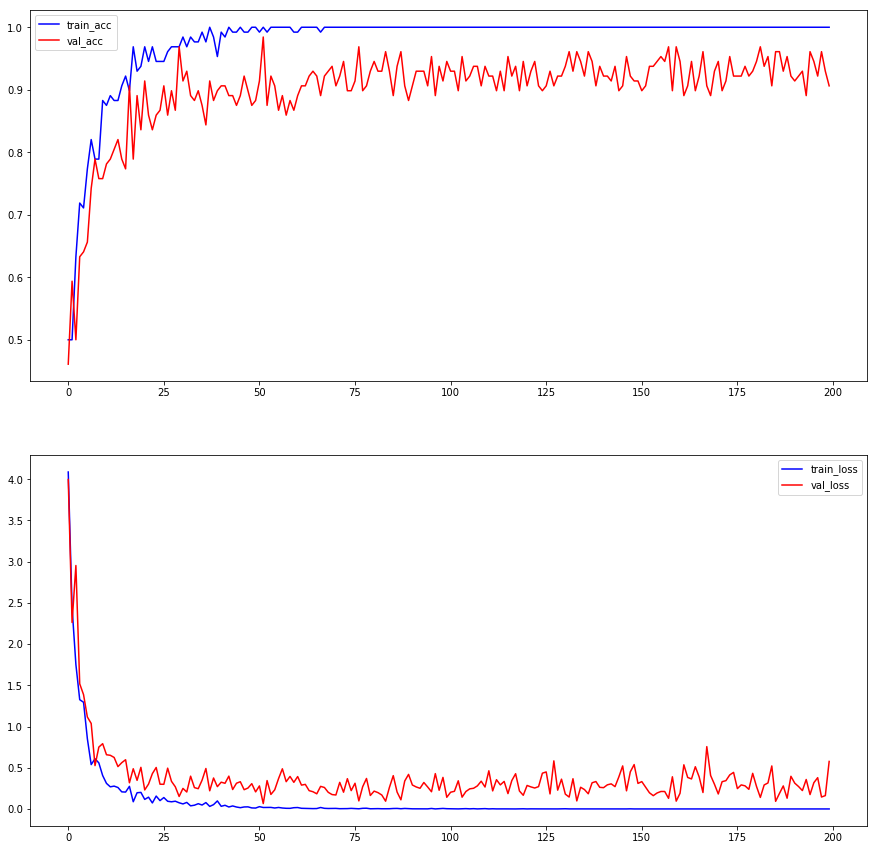

In [84]:
#Plot accuracy and loss
plt.figure(figsize=(15,15))
plt.subplot(211)
plt.plot(hist['train_acc'],'-b',label='train_acc')
plt.plot(hist['val_acc'],'-r',label='val_acc')
plt.legend()
plt.subplot(212)
plt.plot(hist['train_loss'],'-b',label='train_loss')
plt.plot(hist['val_loss'],'-r',label='val_loss')
plt.legend()

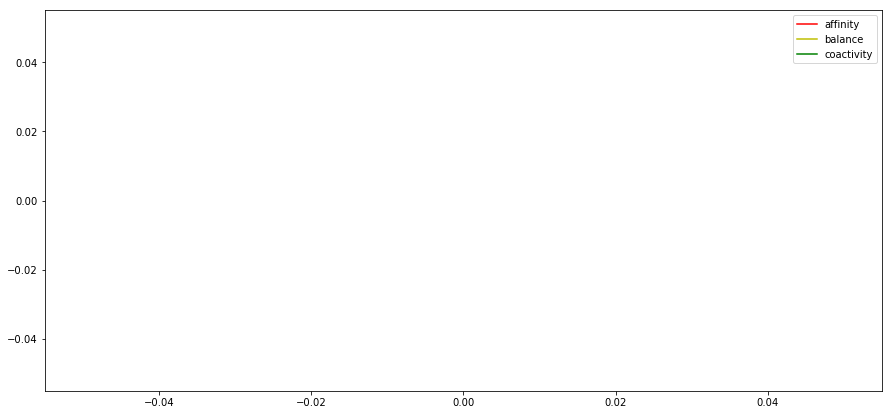

In [85]:
plt.figure(figsize=(15,7))
#plt.plot(hist['train_loss'],'-b',label='train_loss')
plt.plot(hist['affinity'],'-r',label='affinity')
plt.plot(np.subtract(1,hist['balance']),'-y',label='balance')
plt.plot(hist['coactivity'],'-g',label='coactivity')
plt.legend()

In [86]:
digitTrace = np.zeros((classCount*clustCount,784))
digitTraceCount = np.zeros((classCount*clustCount))
digitCount = np.zeros(10)

NameError: name 'clustCount' is not defined

In [ ]:
#sess.run(tf.global_variables_initializer())
for i in range(1000):
    testbatch = next_batch(1,True,test_images, test_labels, test_super_labels,_epochs_completed_test,_index_in_epoch_test)
    lbl = testbatch[2].ravel()
    digitCount[np.argmax(lbl)]+=1
    smMat, acc = sess.run([softmaxMat,accuracy],feed_dict={x: testbatch[0], y_: testbatch[1], y2_:testbatch[2],keep_prob:1.0})
    ypred = softmaxMat.eval({x: testbatch[0], y_: testbatch[1], y2_:testbatch[2],keep_prob:1.0})
    ypred.reshape(10)
    digitTrace[np.argmax(ypred),:] += testbatch[0].ravel()
    digitTraceCount[np.argmax(ypred)] += 1

In [ ]:
print(digitCount)
print(digitTraceCount)

In [ ]:
digitTrace = digitTrace/np.max(digitTrace)
f,ax=plt.subplots(nrows=classCount, ncols=clustCount, figsize=(1.5*clustCount,1.5*classCount))
gs = gridspec.GridSpec(classCount,clustCount)
gs.update(wspace=0.025, hspace=0.025)
f.subplots_adjust(wspace=0,hspace=0)
for i in range(digitTrace.shape[0]):
    sp = plt.subplot(gs[i])
    sp.set_xticklabels([])
    sp.set_yticklabels([])
    sp.set_aspect('equal')
    sp.grid = False
    plt.imshow(np.reshape(digitTrace[i,:],(28,28)),cmap='bone')

In [ ]:
stepCount = len(hist['train_acc'])*100
with open('./trainlog.txt','ab') as f:
    f.write('lr: %g, batchsize: %i, steps: %i, thresh: %g, c1: %g, c2: %g, c3: %g, c4: %g, test_acc: %g, test_loss: %g\n'%
            (lr,batchSize,stepCount,tresh.eval(), cc1, cc2, cc3, cc4, test_acc, test_loss))

## Clustering score

In [ ]:
testbatch = next_batch(10000,True,test_images, test_labels, test_super_labels,_epochs_completed_test,_index_in_epoch_test)
lbls = testbatch[2].reshape(10000,10)
testFeed = {x: testbatch[0], y_: testbatch[1],y2_:testbatch[2],keep_prob:1.0}
ypred = softmaxMat.eval(testFeed)
ypred = ypred.reshape((testbatch[0].shape[0],clustCount*classCount))
print(np.argmax(ypred,1).shape)
ypred = tf.argmax(ypred,1).eval()
ylookup = [np.argmax(np.sum(testbatch[2][ypred==i],0)).astype('int32') for i in range(clustCount*classCount)]
yconverted = [ylookup[i] for i in ypred]
correct_prediction = tf.equal(yconverted, np.argmax(lbls,1).astype('int32'))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).eval()
print('Clustering Accuracy: %g'%(accuracy))
print(ylookup)
print(testbatch[2].shape)

## Compare it to k-means

In [ ]:
tb0 = [tb[0][np.argmax(tb[1],1)<5],tb[1][np.argmax(tb[1],1)<5]]
tb1 = [tb[0][np.argmax(tb[1],1)>4],tb[1][np.argmax(tb[1],1)>4]]
#<5
kmeans = KMeans(n_clusters=5)
km0_ypred = kmeans.fit_transform(tb0[0])
km0_ypred = np.argmax(km0_ypred,1)
km_ylookup = [np.argmax(np.sum(tb0[1][km0_ypred==i],0)).astype('int32') for i in range(clustCount)]
km_yconverted = [km_ylookup[i] for i in km0_ypred]
km_correct_prediction = tf.equal(km_yconverted, np.argmax(tb0[1],1).astype('int32'))
km0_accuracy = tf.reduce_mean(tf.cast(km_correct_prediction, tf.float32)).eval()
#>4
kmeans = KMeans(n_clusters=5)
km1_ypred = kmeans.fit_transform(tb1[0])
km1_ypred = np.argmax(km1_ypred,1)
km_ylookup = [np.argmax(np.sum(tb1[1][km1_ypred==i],0)).astype('int32') for i in range(clustCount)]
km_yconverted = [km_ylookup[i] for i in km1_ypred]
km_correct_prediction = tf.equal(km_yconverted, np.argmax(tb1[1],1).astype('int32'))
km1_accuracy = tf.reduce_mean(tf.cast(km_correct_prediction, tf.float32)).eval()
print('ACOL Accuracy: %g'%(accuracy))
print('KMeans Accuracy: %g'%((km0_accuracy+km1_accuracy)/2))

In [ ]:
#visualise kmeans
digitTrace = np.concatenate([[np.sum(tb0[0][km0_ypred==i,:],axis=0) for i in range(clustCount)],
                       [np.sum(tb1[0][km1_ypred==i,:],axis=0) for i in range(clustCount)]])
digitTrace = digitTrace/np.max(digitTrace)
f,ax=plt.subplots(nrows=classCount, ncols=clustCount, figsize=(1.5*clustCount,1.5*classCount))
gs = gridspec.GridSpec(classCount,clustCount)
gs.update(wspace=0.025, hspace=0.025)
f.subplots_adjust(wspace=0,hspace=0)
for i in range(digitTrace.shape[0]):
    sp = plt.subplot(gs[i])
    sp.set_xticklabels([])
    sp.set_yticklabels([])
    sp.set_aspect('equal')
    sp.grid = False
    plt.imshow(np.reshape(digitTrace[i,:],(28,28)),cmap='bone')